# <span style="color:red">  **SIMULATIONS ET MÉTHODES DE MONTE CARLO**  </span>

In [2]:
import numpy as np 
from scipy.stats import multivariate_normal
import Estimateurs
import Code
import matplotlib.pyplot as plt

<span style="color:blue">  **NOTATIONS**  </span> : on se donne un ensemble de données $\boldsymbol{x} = \{x^{(i)}\}_{i=1}^n$ composé de $n$ échantillons i.i.d. d'une variable continue ou discrète $x$ à valeurs dans un espace d'observations $\boldsymbol{\mathcal{X}}$ (ainsi $\boldsymbol{x} \in \boldsymbol{\mathcal{X}}$). Nous supposons que les données sont générées par un processus aléatoire impliquant une variable aléatoire continue non observée $\boldsymbol{z} = \{z^{(i)}\}_{i=1}^n$ à valeur dans un espace d'observations $\boldsymbol{\mathcal{Z}}$ (ainsi $\boldsymbol{z} \in \boldsymbol{\mathcal{Z}}$). Le processus se compose de deux étapes :


1. La valeur $z^{(i)}$ est générée à partir d'une distribution a priori $p_{\theta^*}(z)$ ;
2. Une valeur $x^{(i)}$ est générée à partir d'une distribution conditionnelle $p_{\theta^*}(x|z)$.


Nous supposons que la distribution a priori $p_{\theta^*}(\boldsymbol{z})$ et la vraisemblance $p_{\theta^*}(\boldsymbol{x}|\boldsymbol{z})$ proviennent de familles paramétriques de distributions $p_{\theta}(\boldsymbol{z})$ et $p_{\theta}(\boldsymbol{x}|\boldsymbol{z})$ et on note $\Theta \subset \mathbb{R}^d$ l'espace des paramètres. On connait ainsi l'expression de ces deux distributions. En revanche une grande partie de ce processus nous est cachée : les véritables paramètres $\theta^*$ ainsi que les valeurs des $\textbf{variables latentes}$ $z^{(i)}$ nous sont inconnus. 

Connaissant l'expression de la distribution a priori $p_{\theta^*}(\boldsymbol{z})$ et la vraisemblance $p_{\theta^*}(\boldsymbol{x}|\boldsymbol{z})$ pour tout $\theta \in \Theta$, on peut définir la densité jointe $p_{\theta}(\boldsymbol{x}, \boldsymbol{z})$ sur $\boldsymbol{\mathcal{X}} \times \boldsymbol{\mathcal{Z}}$ par : 

$$
p_{\theta}(\boldsymbol{x}, \boldsymbol{z}) = p_{\theta}(\boldsymbol{x}|\boldsymbol{z}) p_{\theta}(\boldsymbol{z})
$$

<span style="color:blue">  **OBJECTIF**  </span> : on cherche à déterminer la vraie valeur du paramètre (ici $\theta^*$) ainsi que les valeurs des variables latentes. 

Une approche classique pour apprendre $\boldsymbol{\theta}$ est de choisir, si celle-ci existe, la valeur de ce paramètre qui maximise la log-vraisemblance marginale de l’ ́echantillon définie par :

$$
\ell(\boldsymbol{\theta}) = \log p_{\boldsymbol{\theta}}(\boldsymbol{x}) = \log \int_{\boldsymbol{\mathcal{Z}}} p_{\boldsymbol{\theta}}(\boldsymbol{x}, \boldsymbol{z}) d\boldsymbol{z}
$$

<span style="color:blue">  **PROBLÈME**  </span> : l'intégrale donnée en ci-dessus est intractable (nous ne pouvons donc pas évaluer ou différencier la vraisemblance marginale).

<span style="color:blue">  **SOLUTION**  </span> : dans le but de résoudre les problèmes ci-dessus, introduisons un **modèle de reconnaissance** (paramétrique) {$ q_{\phi}(\boldsymbol{z}|\boldsymbol{x}) : \phi \in \Phi$} avec $\Phi \subset \mathbb{R}^d$. Pour tout $\phi$, $q_{\phi}(\boldsymbol{z}|\boldsymbol{x})$ est choisi comme une approximation de la véritable postérieure intractable $p_{\theta}(\boldsymbol{z}|\boldsymbol{x})$. L'idée est donc de proposer une valeur de l'a posteriori (faire une hypothèse) et d'introduire une méthode pour apprendre les paramètres du **modèle de reconnaissance** $\phi$ conjointement avec les paramètres du **modèle génératif** $\theta$.

## <span style="color:green">  **Partie 0. Définition du cadre gaussien pour la génération des données**  </span>

(Application numérique inspirée de [Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf))

- Le **modèle génératif** est donné par $p_{\theta}(\boldsymbol{x}, \boldsymbol{z}) = \mathcal{N}(\boldsymbol{z}|\theta, I) \mathcal{N}(\boldsymbol{x}|\boldsymbol{z}, I)$, où $\boldsymbol{x}$ et $\boldsymbol{z} \in \mathbb{R}^{20}$, de sorte que $p_{\theta}(\boldsymbol{x}) = \mathcal{N}(\boldsymbol{x}|\theta, 2I)$ et $p_{\theta}(\boldsymbol{z}|\boldsymbol{x}) = \mathcal{N}\left( \frac{\theta + x}{2}, \frac{1}{2}I \right)$. 

- La **distribution de l'encodeur** (le modèle de reconnaissance) est $q_{\phi}(z|x) = \mathcal{N}\left(\boldsymbol{z}|A\boldsymbol{x} + b, \frac{2}{3}I \right)$, où $\phi = (A, b)$.

- Nous considérons des perturbations aléatoires des paramètres près de la valeur optimale par une distribution gaussienne de moyenne nulle et d'écart-type $0.01$.

**Dans ce cas, on peut analytiquement calculer la vraie log-vraisemblance du modèle pour quantifier le biais et la variance de tous les estimateurs**.

Puisque $q_{\phi}(z|x) = \mathcal{N}\left(\boldsymbol{z}|A\boldsymbol{x} + b, \frac{2}{3}I \right)$ est censé être une approximation de la véritable loi a posteriori donnée par $p_{\boldsymbol{\theta}}(\boldsymbol{z} | \boldsymbol{x}) = \mathcal{N}\left( \frac{\theta + x}{2}, \frac{1}{2}I \right)$

On commence par tirer le $\theta$* ($\in \mathbb{R}$) qui sera le paramètre que l'on cherchera à estimer par la suite. 

A la manière de la génération des données dans [Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf) : $\theta^* \sim \mathcal{N}(0, 1)$

In [3]:
#theta_true = np.random.multivariate_normal(np.zeros(20), np.identity(20))
theta_true = np.random.normal(0, 1)
print(f"La valeur de theta à estimer est {int(theta_true*100)/100}")

La valeur de theta à estimer est 0.51


L'idée est désormais de tirer une observation $\boldsymbol{x} \in \mathbb{R}^{20}$, chose que l'on peut faire puisque toutes les distributions nous sont données. 


In [4]:
## On se donne notre échantillon x

x, _ = Estimateurs.joint_probability(theta_true)

print(f"L'échantillon x observé est :\n \n x = {x} \n \n et on vérifique bien sa taille est celle voulue : {x.shape}")

L'échantillon x observé est :
 
 x = [ 1.928247    0.15408191  0.6364203   2.37309744  0.71065515  1.32836867
  3.49899965 -0.24039715  0.58757412  1.2041936   2.34734599 -0.03025229
  0.34219638  1.23651048  0.28360317  0.92081904  0.85326205  1.33059416
  3.15605168 -1.46738537] 
 
 et on vérifique bien sa taille est celle voulue : (20,)


Il est maintenant question de tirer notre encodeur tel que : $q_{\phi}(z|x) = \mathcal{N}\left(\boldsymbol{z}|A\boldsymbol{x} + b, \frac{2}{3}I \right)$, où $\phi = (A, b)$. **Le problème qui se pose est donc celui du choix de $A$ et de $b$**. Dans l'article [Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf), il nous est indiqué : 

*"Following [Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf), we consider random perturbations of the parameters near the optimal value by a zero-mean Gaussian with standard deviation 0.01"*

Ainsi, étant donné une observation $\boldsymbol{x}$,  le choix parfait pour $\phi$ serait $\phi^* = (A^*, b^*)$ où $A^* = \frac{1}{2}\boldsymbol{I}_{20} \in \mathbb{R}^{20 \times 20}$ et $b^* = [\frac{\theta^*}{2}, ..., \frac{\theta^*}{2}]^T \in \mathbb{R}^{20} $. Suivant l'indication dans l'article, nous nous plaçons dans un cas où on aurait réussi à inférer de manière convenable la loi $p_{\theta}(\boldsymbol{z}|\boldsymbol{x}) = \mathcal{N}\left( \frac{\theta + x}{2}, \frac{1}{2}I \right)$, mais pas parfaitement. Ainsi,  on introduit de la même façon que dans l'article [[Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf) une perturbation autour de la valeur optimale du paramètre $\phi$. Cette perturbation se caractérise par le fait chaque dimension de chaque paramètre a été décalée de manière aléatoire par rapport à sa valeur optimale en utilisant une gaussienne centrée en zéro avec un écart-type de 0,01.


In [5]:
dim = 20 

## On calcule les valeurs optimales de A et de b
A = 0.5 * np.eye(dim)
b = 0.5 * theta_true * np.ones(dim)

## On calcule les valeurs perturbées de A et de b, qui sont FIXÉES dans la suite
noised_A, noised_b = Code.noised_params(A, b)

print(f"On vérifie que les tailles de A, b et x coincident :\n \n taille A : {A.shape} \n taille b : {b.shape} \n taille x : {x.shape}")

On vérifie que les tailles de A, b et x coincident :
 
 taille A : (20, 20) 
 taille b : (20,) 
 taille x : (20,)


In [9]:
r = 0.6

def roulette_russe(r, I_0, Delta, K):

    '''
    ---------------------------------------------------------------------------------------------------------------------
    IDEA: compute the rr estimator under the conditions of theorem 1 and a geometric distribution of parameter r for the 
            number of parameters in the sum 
    ---------------------------------------------------------------------------------------------------------------------

    ---------------------------------------------------------------------------------------------------------------------
    ARGUMENTS: 
    - I_0: float ; see the theoretical framework in the article for more details
    
    - Delta: lambda function to compute the ∆_k such as in the theoretical framework of the paper

    - K: integer, sampled according to a law on N (positive integers)
    ---------------------------------------------------------------------------------------------------------------------
    '''

    return I_0 + sum(Delta(k)/((1-r)**(k)) for k in range(1,K))

K = np.random.geometric(p=r)

## K+3 pour avoir de quoi aller jusque K+3
z_sample_theta, _, _ = Code.generate_encoder(x, K+2, noised_A, noised_b)

weights_array = Code.weights(x, z_sample_theta, theta_true, noised_A, noised_b)
    
I_0 = np.mean([weights_array])

## on se donne un delta particulier, celui qui correspond par définition à la méthode SUMO
Delta_theta = lambda j: np.log(np.mean(weights_array[:j+2])) - np.log(np.mean(weights_array[:j+1]))

roulette_russe(r, I_0, Delta_theta, K)

-0.2802782992552325

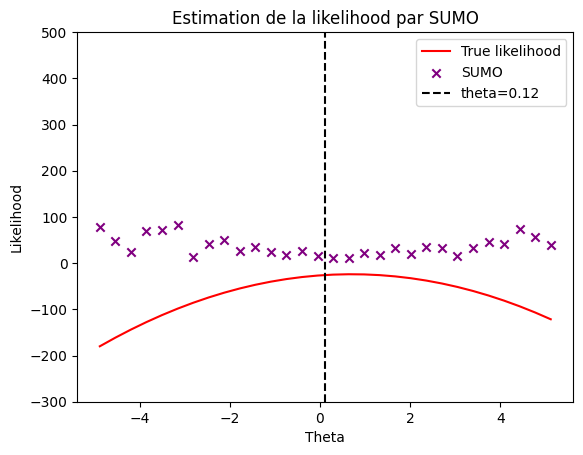

([-180.00437079915827,
  -161.3410233817398,
  -143.8667366064141,
  -127.58151047318113,
  -112.48534498204087,
  -98.57824013299339,
  -85.86019592603867,
  -74.33121236117668,
  -63.991289438407435,
  -54.840427157730936,
  -46.8786255191472,
  -40.105884522656204,
  -34.52220416825795,
  -30.127584455952444,
  -26.922025385739694,
  -24.90552695761968,
  -24.078089171592417,
  -24.439712027657897,
  -25.99039552581613,
  -28.730139666067103,
  -32.65894444841083,
  -37.7768098728473,
  -44.08373593937651,
  -51.57972264799847,
  -60.26476999871319,
  -70.13887799152066,
  -81.20204662642087,
  -93.45427590341383,
  -106.89556582249948,
  -121.52591638367792],
 [78.61092522003798,
  46.81549088879912,
  24.946509420487555,
  70.53659535446249,
  71.62245565697546,
  81.89391552546992,
  12.718513929076066,
  41.98244233087972,
  50.18946366940512,
  25.959664843649254,
  35.89479469567196,
  23.80149685163566,
  17.948135614072754,
  25.517262962015746,
  15.799795958423612,
  11.27

In [6]:
estimateur.plot_likelihood(theta_true, 1, 'SUMO')